# About the Data

* UTC: Time Stamp
* Temperature: Air Temperature
* Humidity%: Air Humidity
* TVOC[ppb]: Total Volatile Organic Compounds; measured in parts per billion
* eCO2[ppm]: co2 equivalent concentration; calculated from different values like TVCO
* Raw H2: raw molecular hydrogen
* Raw Ethanol: raw ethanol gas
* Pressure[hPa]: Air Pressure
* PM1.0: particulate matter size < 1.0 µm (PM1.0). 1.0 µm < 2.5 µm (PM1.0)
* PM2.5: particulate matter size < 1.0 µm (PM1.0). 1.0 µm < 2.5 µm (PM2.5)
* NC0.5: Number concentration of particulate matter.
* NC1.0: Number concentration of particulate matter.
* CNT: Sample counter.
* Fire Alarm: Ground truth is "1" if a fire is there.

**Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_curve, precision_recall_fscore_support


**Import Dataset**

In [ ]:
df=pd.read_csv("/content/smoke_detection_iot.csv")

**Data preprocessing**

In [ ]:
df.head()

,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,0
1,1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,1,0
2,2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,2,0
3,3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,3,0
4,4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,4,0


In [ ]:
df.shape

(62630, 16)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62630 entries, 0 to 62629
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      62630 non-null  int64  
 1   UTC             62630 non-null  int64  
 2   Temperature[C]  62630 non-null  float64
 3   Humidity[%]     62630 non-null  float64
 4   TVOC[ppb]       62630 non-null  int64  
 5   eCO2[ppm]       62630 non-null  int64  
 6   Raw H2          62630 non-null  int64  
 7   Raw Ethanol     62630 non-null  int64  
 8   Pressure[hPa]   62630 non-null  float64
 9   PM1.0           62630 non-null  float64
 10  PM2.5           62630 non-null  float64
 11  NC0.5           62630 non-null  float64
 12  NC1.0           62630 non-null  float64
 13  NC2.5           62630 non-null  float64
 14  CNT             62630 non-null  int64  
 15  Fire Alarm      62630 non-null  int64  
dtypes: float64(8), int64(8)
memory usage: 7.6 MB


**First, We need to remove the columns that are not necessary for this task.**

In [ ]:
df.drop(columns=['UTC', 'CNT'], inplace= True)

In [ ]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [ ]:
df.head()

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,Fire Alarm
0,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0
1,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,0
2,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,0
3,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,0
4,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
df.shape

(62630, 13)

In [ ]:
df.isnull().sum()
df = df.dropna()

High Correlation Pairs:
Columns 'PM1.0' and 'PM2.5' have correlation value: 0.96
Columns 'PM1.0' and 'NC0.5' have correlation value: 0.94
Columns 'PM1.0' and 'NC1.0' have correlation value: 0.95
Columns 'PM1.0' and 'NC2.5' have correlation value: 0.85
Columns 'PM2.5' and 'NC1.0' have correlation value: 1.00
Columns 'PM2.5' and 'NC2.5' have correlation value: 0.97
Columns 'NC1.0' and 'NC2.5' have correlation value: 0.97


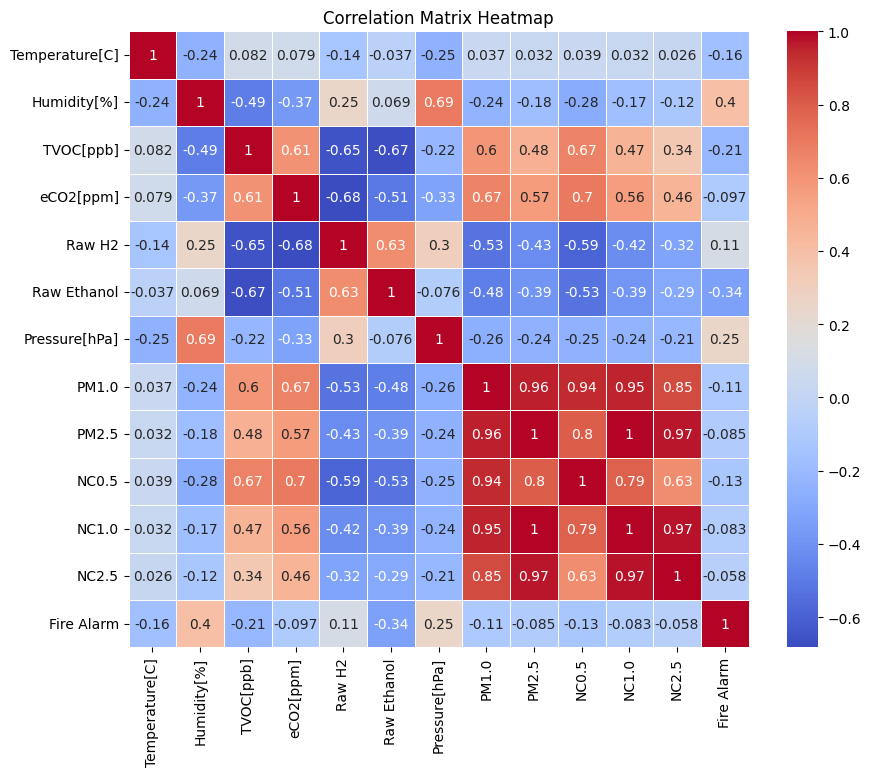

In [ ]:
correlation_matrix = df.corr()   # Compute the correlation matrix

plt.figure(figsize=(10, 8))      # Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')

columns_to_drop = []

high_correlation_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        column1 = correlation_matrix.columns[i]
        column2 = correlation_matrix.columns[j]
        correlation_value = correlation_matrix.iloc[i, j]
        if abs(correlation_value) > 0.8:
            high_correlation_pairs.append((column1, column2, correlation_value))
            columns_to_drop.append(column2)  # Drop the second column from each high correlation pair

print("High Correlation Pairs:")
for pair in high_correlation_pairs:
    print(f"Columns '{pair[0]}' and '{pair[1]}' have correlation value: {pair[2]:.2f}")

df = df.drop(columns=columns_to_drop)      # Remove columns with high correlation
plt.show()

In [ ]:
df.head()

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,Fire Alarm
0,20.000,57.36,0,400,12306,18520,939.735,0.0,0
1,20.015,56.67,0,400,12345,18651,939.744,0.0,0
2,20.029,55.96,0,400,12374,18764,939.738,0.0,0
3,20.044,55.28,0,400,12390,18849,939.736,0.0,0
4,20.059,54.69,0,400,12403,18921,939.744,0.0,0


<ipython-input-13-1dc368a8e961>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Fire Alarm', data=df, ax=axes[0], palette=['blue', 'red'])


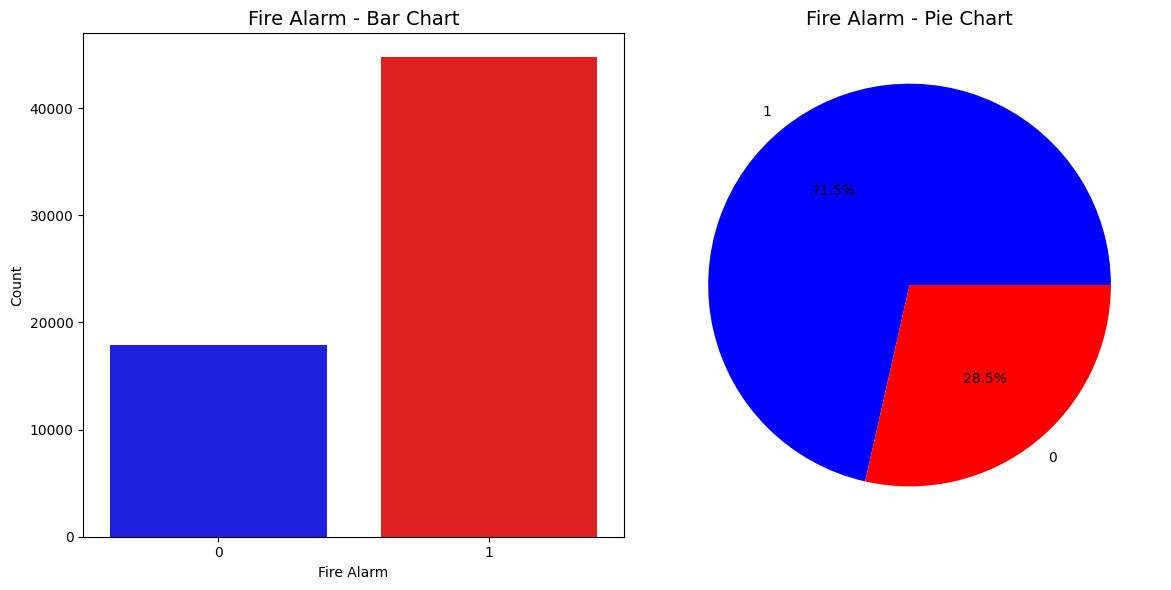

In [ ]:
class_counts = df['Fire Alarm'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot bar chart
sns.countplot(x='Fire Alarm', data=df, ax=axes[0], palette=['blue', 'red'])
axes[0].set_ylabel('Count')
axes[0].set_title('Fire Alarm - Bar Chart', color='black', fontsize=14)

# Plot pie chart
class_counts.plot(kind='pie', autopct='%1.1f%%', colors=['blue', 'red'], ax=axes[1])
axes[1].set_ylabel('')
axes[1].set_title('Fire Alarm - Pie Chart', color='black', fontsize=14)


plt.tight_layout()
plt.show()

**Since, the traget variable is not blanaced, we need to first balance the traget variable in order to get more accuaracy.**


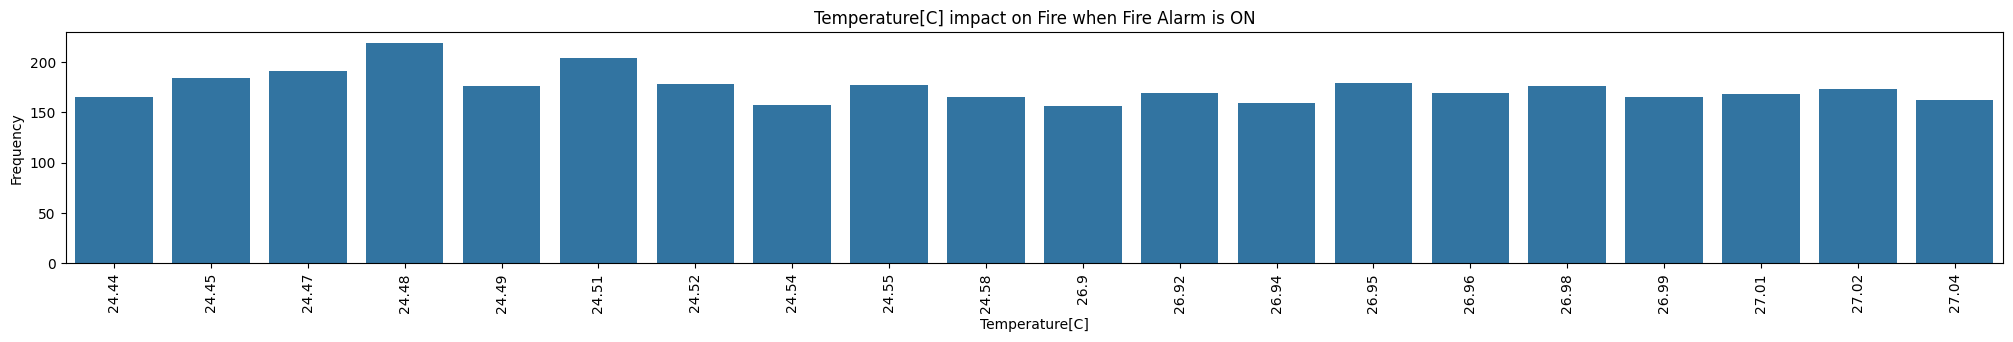

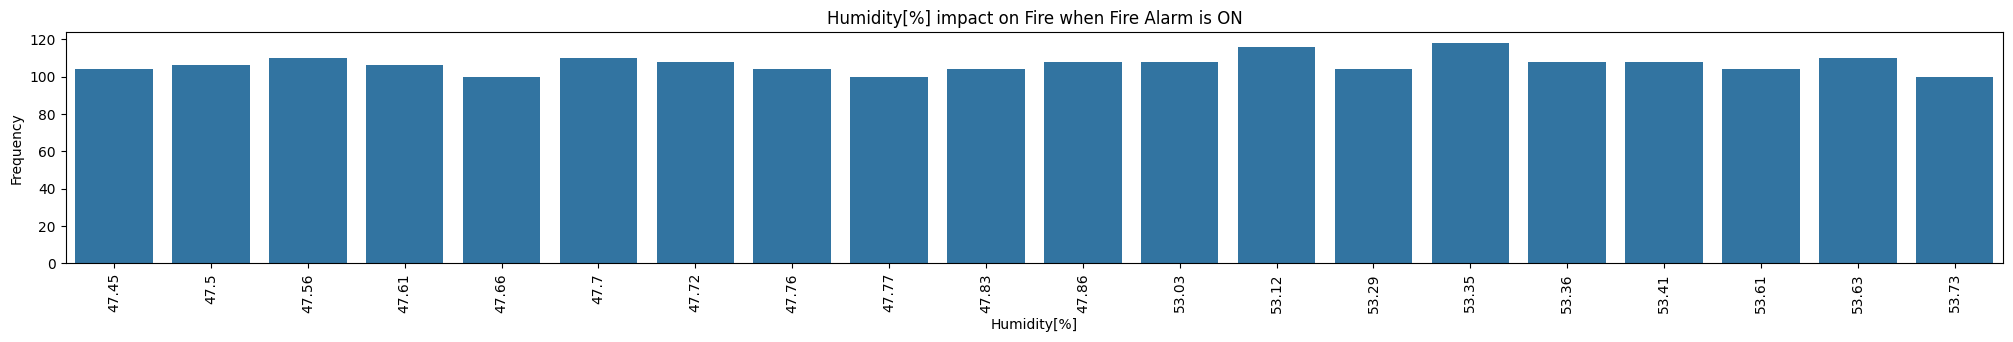

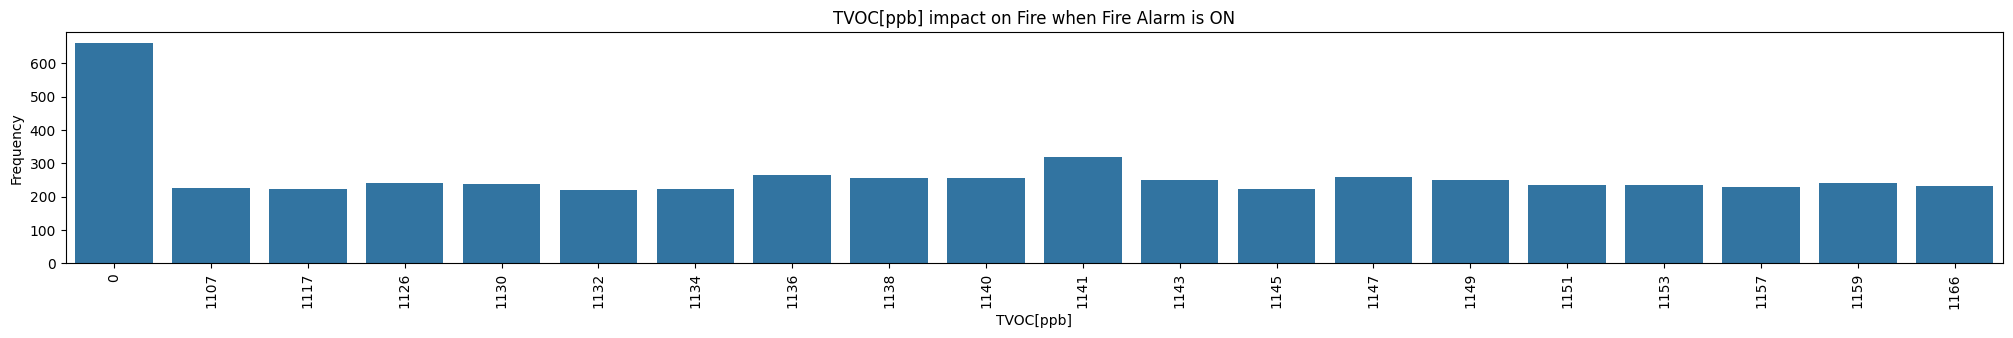

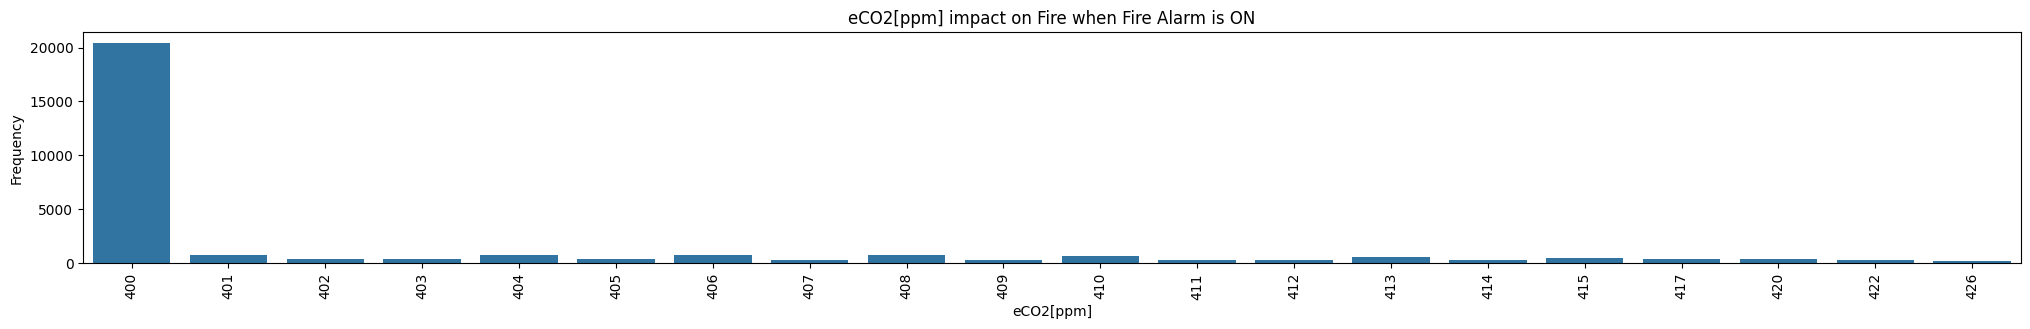

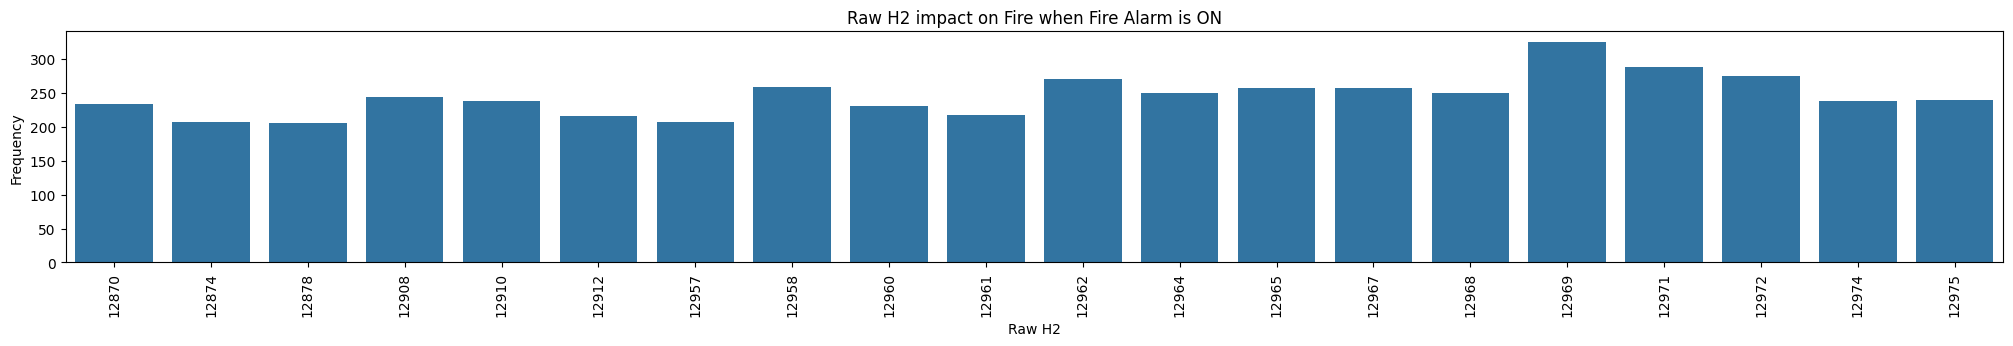

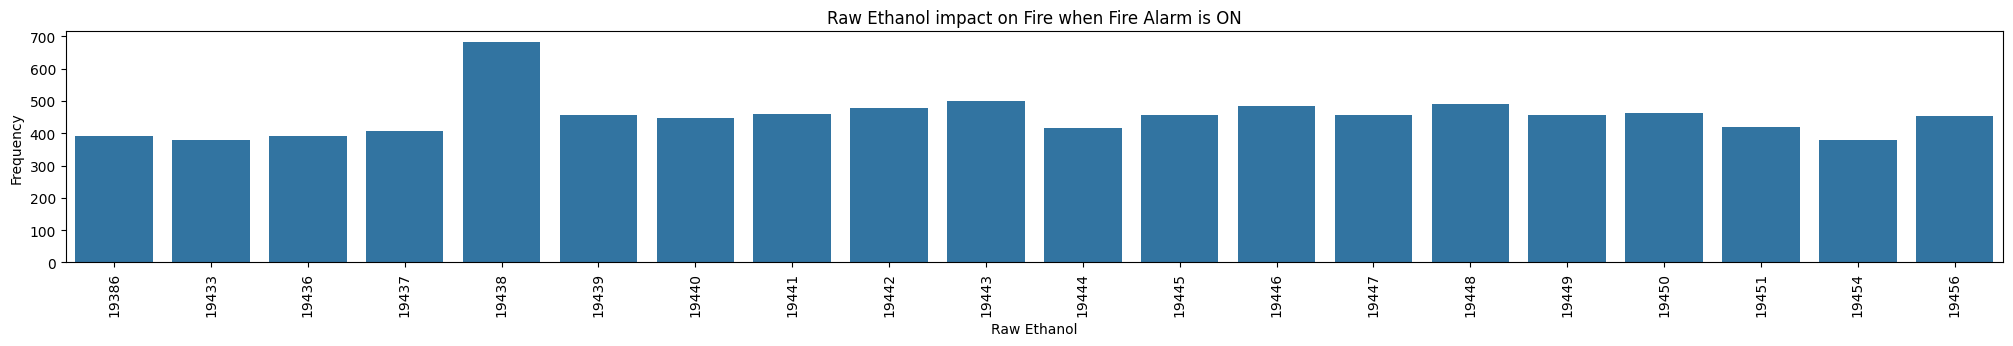

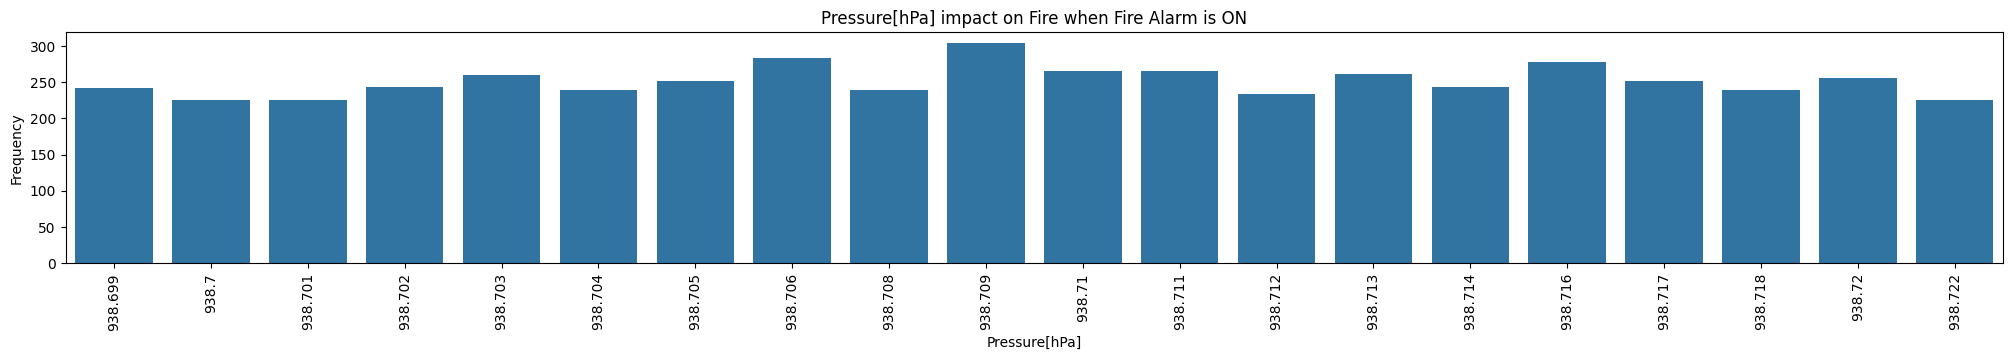

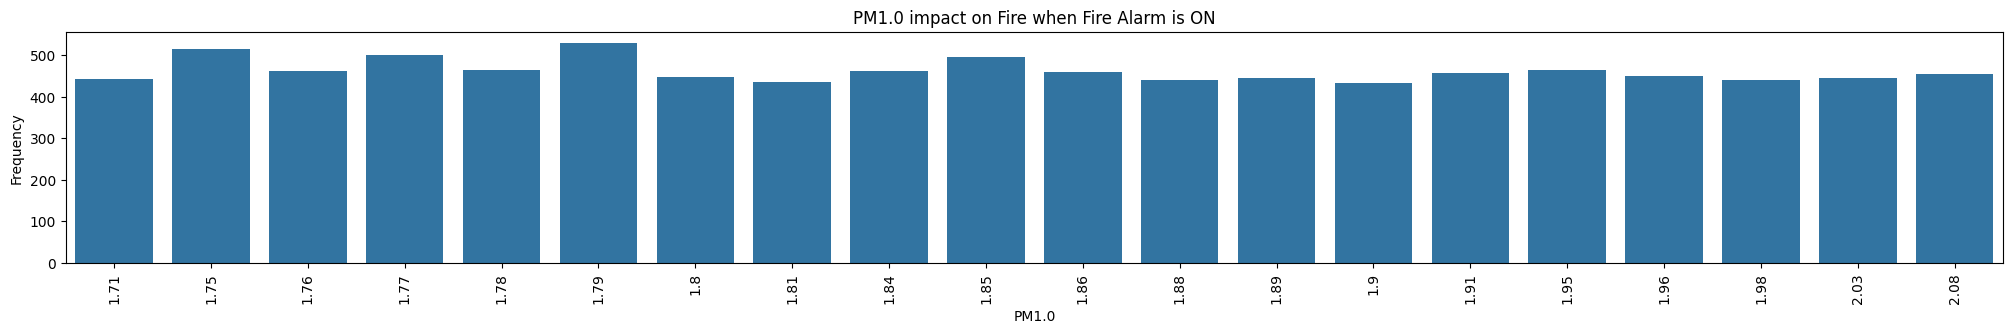

In [ ]:
numerical_columns = ['Temperature[C]', 'Humidity[%]', 'TVOC[ppb]', 'eCO2[ppm]', 'Raw H2', 'Raw Ethanol','Pressure[hPa]', 'PM1.0']

df_fire_alarm_1 = df[df['Fire Alarm'] == 1]

for column in numerical_columns:
    column_fire = df_fire_alarm_1.groupby(column)['Fire Alarm'].count().sort_values(ascending=False).head(20)
    plt.figure(figsize=[25, 3])
    sns.barplot(x=column_fire.index, y=column_fire.values)
    plt.title(f'{column} impact on Fire when Fire Alarm is ON')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.show()


**From the above graphs, we found that " eCO2[ppm] " is not having much impact on the target variable. SO, we need to remove that column also.**

In [ ]:
df.drop(columns=['eCO2[ppm]'], inplace= True)
df.head()

,Temperature[C],Humidity[%],TVOC[ppb],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,Fire Alarm
0,20.000,57.36,0,12306,18520,939.735,0.0,0
1,20.015,56.67,0,12345,18651,939.744,0.0,0
2,20.029,55.96,0,12374,18764,939.738,0.0,0
3,20.044,55.28,0,12390,18849,939.736,0.0,0
4,20.059,54.69,0,12403,18921,939.744,0.0,0


In [ ]:
X = df.drop(columns='Fire Alarm')
y = df['Fire Alarm']

In [ ]:
y.isnull().sum()

0

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state= 18, stratify= y)

In [ ]:
print("y_train counts for different values:", y_train.value_counts())

print("\ny_test counts for different values:",y_test.value_counts())

y_train counts for different values: Fire Alarm
1    35806
0    14298
Name: count, dtype: int64

y_test counts for different values: Fire Alarm
1    8951
0    3575
Name: count, dtype: int64


**We need to handle the Outliers before balance the dataset.**

In [ ]:
z_scores_x_train = ((x_train - x_train.mean()) / x_train.std()).abs()   # Calculate the Z-scores in the x_train

threshold = 3                                             # threshold for outlier detection

outlier_mask_x_train = z_scores_x_train > threshold       # Create a boolean mask indicating outliers in x_train

x_train_reset_index = x_train.reset_index(drop=True)      # Reset the index of x_train

outlier_mask_x_train_reset_index = outlier_mask_x_train.reset_index(drop=True) # Reset the index of the boolean mask to match x_train_reset_index

x_train_no_outliers = x_train_reset_index[~outlier_mask_x_train_reset_index.any(axis=1)]  # Remove rows containing outliers from x_train

y_train_reset_index = y_train.reset_index(drop=True) # Reset the index of y_train

indices_to_keep_list = [index for index, keep in enumerate(~outlier_mask_x_train_reset_index.any(axis=1)) if keep]

y_train_no_outliers = y_train_reset_index.loc[indices_to_keep_list] # Remove corresponding rows from y_train

# Display the shape of x_train and y_train before and after removing outliers
print("Shape of x_train before removing outliers:", x_train.shape)
print("Shape of y_train before removing outliers:", y_train.shape)

print("Shape of x_train after removing outliers:", x_train_no_outliers.shape)
print("Shape of y_train after removing outliers:", y_train_no_outliers.shape)


Shape of x_train before removing outliers: (50104, 7)
Shape of y_train before removing outliers: (50104,)
Shape of x_train after removing outliers: (47179, 7)
Shape of y_train after removing outliers: (47179,)


In [ ]:
x_train_no_outliers.isnull().sum()

Temperature[C]    0
Humidity[%]       0
TVOC[ppb]         0
Raw H2            0
Raw Ethanol       0
Pressure[hPa]     0
PM1.0             0
dtype: int64

**We use SMOTE to balance the dataset.**

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train_no_outliers, y_train_no_outliers)
print("Value_count of y_train_smote:", y_train_smote.value_counts())

print("Value_count of x_train_smote duplicates:", x_train_smote.duplicated().sum())

Value_count of y_train_smote: Fire Alarm
0    34902
1    34902
Name: count, dtype: int64
Value_count of x_train_smote duplicates: 2


<ipython-input-23-35526bc02ecf>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Fire Alarm', data=df, ax=axes[0], palette=['blue', 'red'])


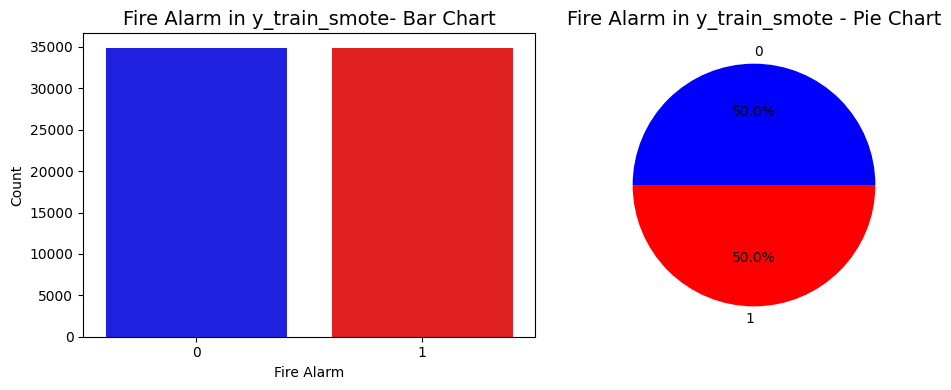

In [ ]:
df = pd.DataFrame({'Fire Alarm': y_train_smote})

value_counts = df['Fire Alarm'].value_counts()
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot bar chart
sns.countplot(x='Fire Alarm', data=df, ax=axes[0], palette=['blue', 'red'])
axes[0].set_ylabel('Count')
axes[0].set_title('Fire Alarm in y_train_smote- Bar Chart', color='black', fontsize=14)

# Plot pie chart
value_counts.plot(kind='pie', autopct='%1.1f%%', colors=['blue', 'red'], ax=axes[1])
axes[1].set_ylabel('')
axes[1].set_title('Fire Alarm in y_train_smote - Pie Chart', color='black', fontsize=14)


plt.tight_layout()

plt.show()


**Model Training**
# Algorithm 1 : Random Forest

Random Forest Classifier:
Train Accuracy: 1.0
Test Accuracy: 0.9826760338495929
F1 Score: 0.9877297144472718
Recall: 0.9757568986705396
Precision: 1.0


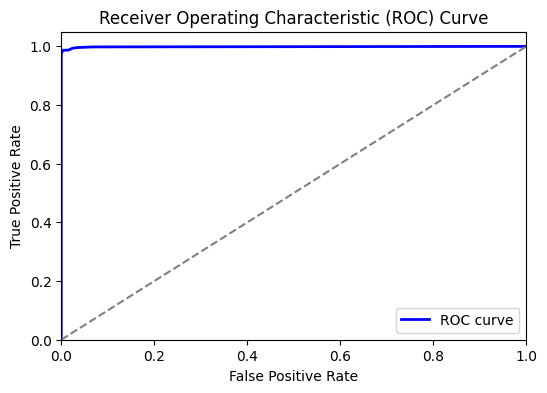

Precision-Recall-F1 Score Table:
   Class  Precision    Recall  F1 Score
0      0   0.942774  1.000000  0.970544
1      1   1.000000  0.975757  0.987730


In [ ]:
rf_pipeline = Pipeline([                             # Create a pipeline with StandardScaler and RandomForestClassifier
    ('scaler', StandardScaler()),                    # StandardScaler for normalization
    ('rf', RandomForestClassifier(random_state=42))  # RandomForestClassifier
])

rf_pipeline.fit(x_train_smote, y_train_smote)        # Fit the pipeline on the training data

rf_train_predictions = rf_pipeline.predict(x_train_smote) # Predictions on the training set

rf_predictions = rf_pipeline.predict(x_test)        # Predictions on the test set

rf_train_accuracy = accuracy_score(y_train_smote, rf_train_predictions) # Calculate metrics
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_f1_score = f1_score(y_test, rf_predictions)
rf_recall = recall_score(y_test, rf_predictions) # Fix: Use recall_score instead of recall
rf_precision = precision_score(y_test, rf_predictions)

print("Random Forest Classifier:")                # Print the metrics
print("Train Accuracy:", rf_train_accuracy)
print("Test Accuracy:", rf_accuracy)
print("F1 Score:", rf_f1_score)
print("Recall:", rf_recall)
print("Precision:", rf_precision)

rf_probs = rf_pipeline.predict_proba(x_test)[:, 1]  # Get predicted probabilities for the positive class

rf_fpr, rf_tpr, thresholds = roc_curve(y_test, rf_probs)   # Compute ROC curve

plt.figure(figsize=(6, 4))                          # Plot ROC curve
plt.plot(rf_fpr, rf_tpr, color='blue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

precision, recall, fscore, _ = precision_recall_fscore_support(y_test, rf_predictions) # Compute precision, recall, F1 score, and support for each class

metrics_table = pd.DataFrame({               # Create a table
    'Class': range(len(precision)),
    'Precision': precision,
    'Recall': recall,
    'F1 Score': fscore
})

print("Precision-Recall-F1 Score Table:")
print(metrics_table)


# Algorithm 2: Support Vector Machine (SVM)


Support Vector Machine (SVM) Classifier:
Train Accuracy: 0.9997707867743969
Test Accuracy: 0.983394539358135
F1 Score: 0.9884700665188471
Recall : 0.996089822366216
Precision: 0.9809660028606008


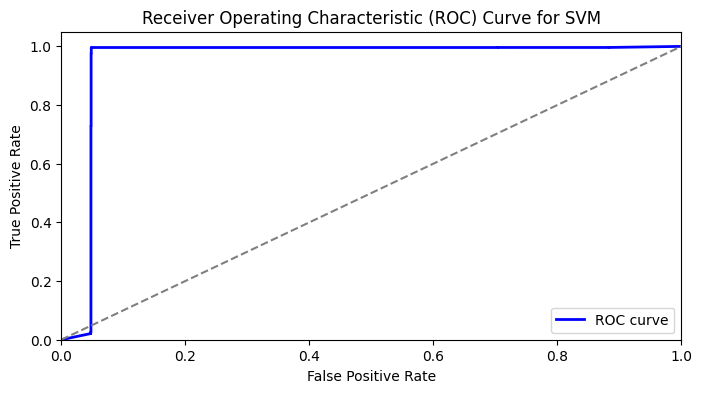


Precision-Recall-F1 Score Table for SVM:
   Class  Precision    Recall  F1 Score
0      0   0.989817  0.951608  0.970337
1      1   0.980966  0.996090  0.988470


In [ ]:
# SVM pipeline definition with probability=True
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),                                   # StandardScaler for normalization
    ('svm', SVC(C=10, kernel='poly', degree=4, gamma='scale', probability=True, random_state=42)) # SVC with polynomial kernel
])

# Fitting the SVM pipeline on the training data
svm_pipeline.fit(x_train_smote, y_train_smote)

# Predictions on the training set
svm_train_predictions = svm_pipeline.predict(x_train_smote)

# Predictions on the test set
svm_predictions = svm_pipeline.predict(x_test)

# Calculating metrics for SVM
svm_train_accuracy = accuracy_score(y_train_smote, svm_train_predictions)
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_f1_score = f1_score(y_test, svm_predictions)
svm_recall =  recall_score(y_test, svm_predictions)
svm_precision = precision_score(y_test, svm_predictions)

# Print SVM metrics
print("\nSupport Vector Machine (SVM) Classifier:")
print("Train Accuracy:", svm_train_accuracy)
print("Test Accuracy:", svm_accuracy)
print("F1 Score:", svm_f1_score)
print("Recall :", svm_recall)
print("Precision:", svm_precision)

# ROC curve for SVM
# Remove the call to predict_proba
svm_probs = svm_pipeline.predict_proba(x_test)[:, 1]  # Get predicted probabilities for the positive class

svm_fpr, svm_tpr, thresholds = roc_curve(y_test, svm_probs)   # Compute ROC curve

plt.figure(figsize=(8, 4))
plt.plot(svm_fpr, svm_tpr, color='blue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for SVM')
plt.legend(loc='lower right')
plt.show()

# Precision-recall-F1 score table for SVM
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, svm_predictions)

metrics_table = pd.DataFrame({
    'Class': range(len(precision)),
    'Precision': precision,
    'Recall': recall,
    'F1 Score': fscore
})

print("\nPrecision-Recall-F1 Score Table for SVM:")
print(metrics_table)


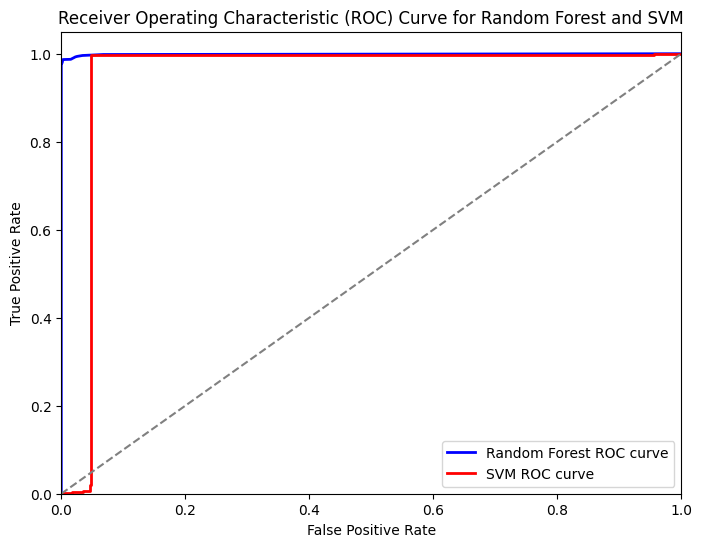

In [ ]:
# Plotting ROC curves for both classifiers
plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, color='blue', lw=2, label='Random Forest ROC curve')
plt.plot(svm_fpr, svm_tpr, color='red', lw=2, label='SVM ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest and SVM')
plt.legend(loc='lower right')
plt.show()

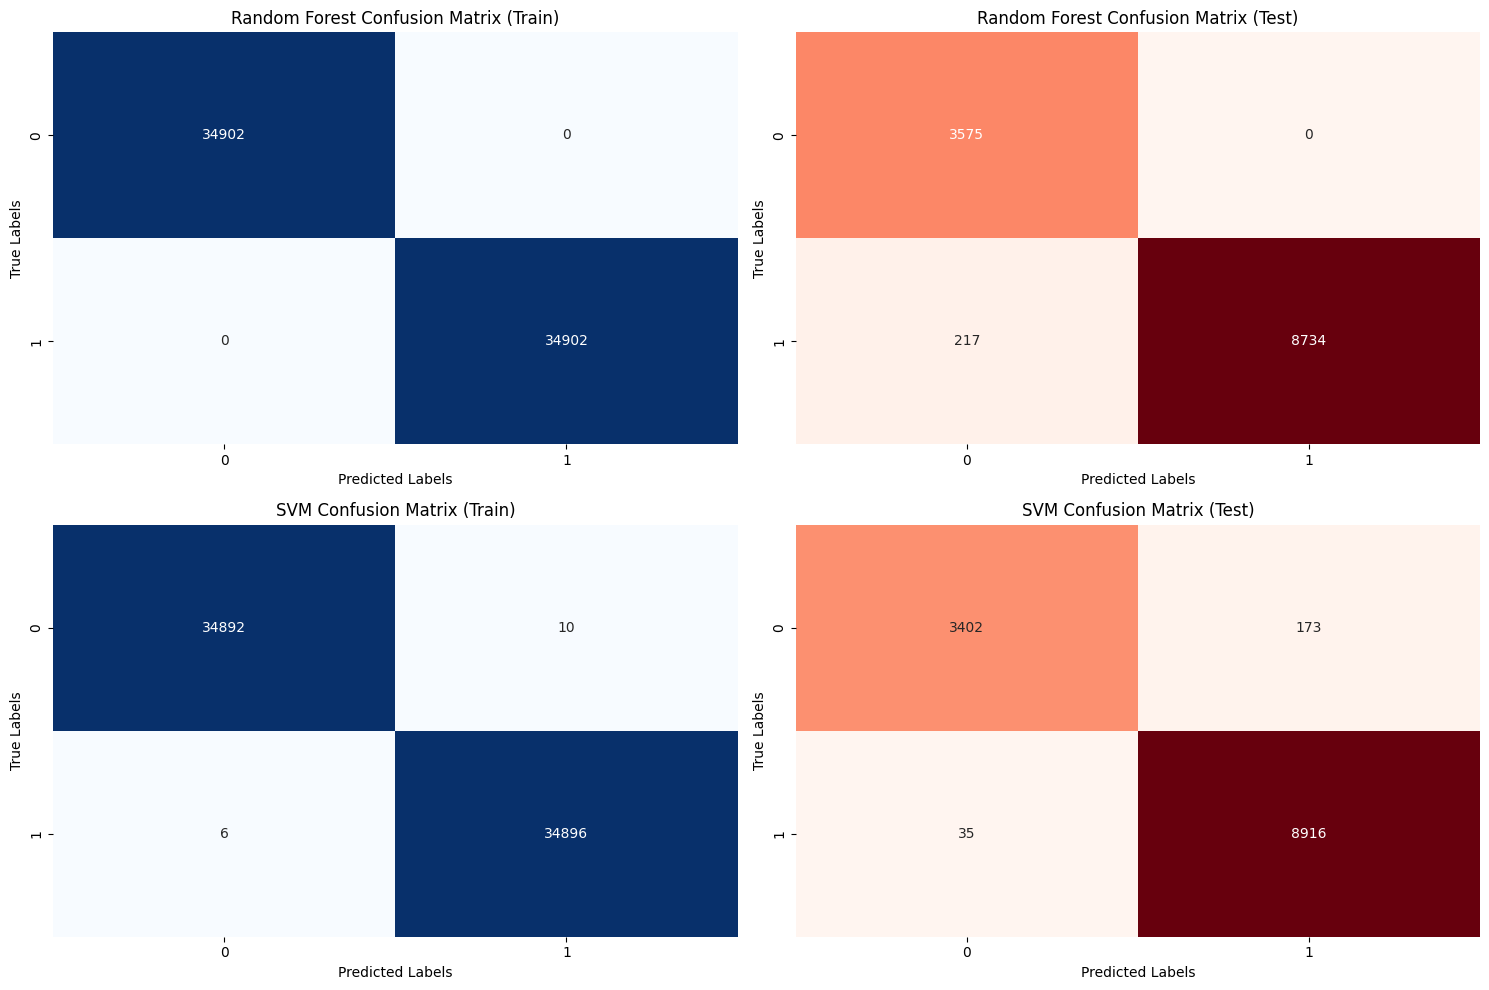

In [ ]:

rf_train_conf_matrix = confusion_matrix(y_train_smote, rf_train_predictions)  # Confusion Matrix for Random Forest (Train)
rf_test_conf_matrix = confusion_matrix(y_test, rf_predictions)                # Confusion Matrix for Random Forest (Test)

svm_train_conf_matrix = confusion_matrix(y_train_smote, svm_train_predictions) # Confusion Matrix for SVM (Train)
svm_test_conf_matrix = confusion_matrix(y_test, svm_predictions)               # Confusion Matrix for SVM (Test)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # Plotting subplots

# Random Forest Confusion Matrix (Train)
sns.heatmap(rf_train_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0, 0])
axes[0, 0].set_title('Random Forest Confusion Matrix (Train)')
axes[0, 0].set_xlabel('Predicted Labels')
axes[0, 0].set_ylabel('True Labels')

# Random Forest Confusion Matrix (Test)
sns.heatmap(rf_test_conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False, ax=axes[0, 1])
axes[0, 1].set_title('Random Forest Confusion Matrix (Test)')
axes[0, 1].set_xlabel('Predicted Labels')
axes[0, 1].set_ylabel('True Labels')

# SVM Confusion Matrix (Train)
sns.heatmap(svm_train_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1, 0])
axes[1, 0].set_title('SVM Confusion Matrix (Train)')
axes[1, 0].set_xlabel('Predicted Labels')
axes[1, 0].set_ylabel('True Labels')

# SVM Confusion Matrix (Test)
sns.heatmap(svm_test_conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False, ax=axes[1, 1])
axes[1, 1].set_title('SVM Confusion Matrix (Test)')
axes[1, 1].set_xlabel('Predicted Labels')
axes[1, 1].set_ylabel('True Labels')

plt.tight_layout()
plt.show()